In [1]:
#!pip install imblearn
#!pip install sklearn-pandas
#!pip install fairlearn
#!pip install https://github.com/adebayoj/fairml/archive/master.zip

### IMPORTING LIBRARIES

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from pandas.api.types import CategoricalDtype

import regex as re

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

from fairmlhealth import report, measure

#import sklearn.metrics
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve, plot_roc_curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

# Algorithm Imports
from sklearn.linear_model import LogisticRegression

# Imbalanced Data
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# AIF360 Imports
from aif360.datasets import AdultDataset
from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.metrics import ClassificationMetric, BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult

from datetime import datetime
from warnings import filterwarnings
filterwarnings(action='ignore')

pd.set_option('display.max_columns', 500)

In [3]:
# Feature categories
protected = 'race'
privileged = ['White']
privileged_groups = [{protected: 1}] # privileged group (males)
unprivileged_groups = [{protected: 0}] # unprivileged group (females)

# Numerical Features
num_features = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
# Categorical Features
cat_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'native-country']

# Dataset instantiation
adult = AdultDataset(
        protected_attribute_names=[protected],
        privileged_classes=[privileged],
        categorical_features=[],
        features_to_keep=num_features)

# Verify that the dataset was initialized properly
print('Features:', adult.feature_names)
print('Target:', adult.label_names)

Features: ['age', 'education-num', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Target: ['income-per-year']


## EDA

Base rate on entire population: 0.24
Base rate on privileged group (white) :0.25
Base rate on unprivileged group (black) :0.15
Statistical parity difference: -0.10
Disparate impact: 0.60


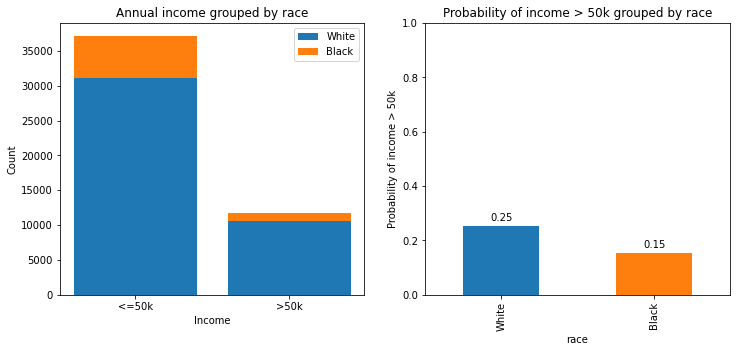

In [17]:
# Fairness-based exploratory data analysis

def analyze_fairness(dataset, data):
    # Separate income by group
    black_income = data[data['race'] == 0]['income-per-year'] # female == 0
    white_income = data[data['race'] == 1]['income-per-year'] # male == 1
    # Dataset metrics
    dm = BinaryLabelDatasetMetric(dataset, privileged_groups=privileged_groups, unprivileged_groups=unprivileged_groups)
    print('Base rate on entire population: {:.2f}'.format(dm.base_rate())) # privileged = None
    print('Base rate on privileged group (white) :{:.2f}'.format(dm.base_rate(privileged=True)))
    print('Base rate on unprivileged group (black) :{:.2f}'.format(dm.base_rate(privileged=False)))
    print('Statistical parity difference: {:.2f}'.format(dm.mean_difference()))
    print('Disparate impact: {:.2f}'.format(dm.disparate_impact()))
    # Plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5)) # [1 x 2] grid
    ax1.bar(['<=50k', '>50k'], white_income.value_counts(), label='White')
    ax1.bar(['<=50k', '>50k'], black_income.value_counts(), bottom=white_income.value_counts(), label='Black')
    ax1.set_xlabel('Income')
    ax1.set_ylabel('Count')
    ax1.set_title('Annual income grouped by race')
    ax1.legend()
    ax2_y = data.groupby('race')['income-per-year'].mean().sort_values(ascending=False)
    ax2_y.plot.bar(x=['White', 'Black'], color=['#1f77b4', '#ff7f0e'], ylim=[0, 1])
    ax2.set_ylabel('Probability of income > 50k')
    ax2.set_title('Probability of income > 50k grouped by race')
    ax2.set_xticklabels(['White', 'Black'])
    for i, v in enumerate(ax2_y):
        ax2.text(i-0.07, v+0.02, '{:.2f}'.format(v))
    plt.show()

# Convert dataset to dataframe
adult_df, _ = adult.convert_to_dataframe()
# Call function
analyze_fairness(adult, adult_df)

### OBESRVATION
- The **'sex'** attribute is dominated by 'Male' with 67% compared to 'Female' values with 33%. Note: the dominance of 'Male' value does not by itself indicate bias/unfair treatment.
- The percentage of males with income > 50k w.r.t. total sample is 20%. The respective percentage of females is 4%.
- The within-class percentage of females with income > 50k is 11%. The respective percentage for males is 30%.
- A number of fairness metrics were calculated for the dataset at hand. More specifically, **statistical parity difference** and **disparate impact** indicate the existence of bias in the dataset.

Note: **Base rate** is defined as $P(Y=1) = P/(P+N)$, optionally conditioned on protected attribute.

In [5]:
# Train Test Split
train, test = adult.split([0.7]) # 0.7 for train, 0.3 for test

# Feature scaling
scaler = MinMaxScaler() # choose min-max scaling
X_train = scaler.fit_transform(train.features)
y_train = train.labels.ravel()

X_test = scaler.transform(test.features) 
y_test = test.labels.ravel()
train.features = scaler.fit_transform(train.features) # fit and transform train (seen) features
test.features = scaler.transform(test.features) # transform test (unseen) features

# Keep index of the protected attribute
protected_idx = train.feature_names.index(protected)
# Verify training and test set dimensions
print('Training set dimensions:', train.features.shape)
print('Test set dimensions:', test.features.shape)

Training set dimensions: (34189, 6)
Test set dimensions: (14653, 6)


# TASK 1

### FIVE FOLD CROSS VALIDATION

In [6]:
# Finding the best accuracy parameters in Logistic Regression
parameters ={'solver':['liblinear','newton-cg'],'random_state':[0,1,2,3]}

lr_cv = GridSearchCV(estimator=LogisticRegression(), param_grid=parameters,
                     scoring=['accuracy','precision','recall','f1_macro','roc_auc'],
                     refit='accuracy', cv=5, verbose=5, error_score='raise')

# Fitting the model for grid search
lr_cv.fit(X_train, y_train)
best_lr_model = lr_cv.best_estimator_
print ('\nThe best parameters for evaluation are as per following:')
print (lr_cv.best_params_)
print("\nThe Accuracy of the best model is: %0.2f" % (100*lr_cv.best_score_))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END random_state=0, solver=liblinear; accuracy: (test=0.811) f1_macro: (test=0.682) precision: (test=0.698) recall: (test=0.365) roc_auc: (test=0.826) total time=   0.0s
[CV 2/5] END random_state=0, solver=liblinear; accuracy: (test=0.807) f1_macro: (test=0.679) precision: (test=0.670) recall: (test=0.369) roc_auc: (test=0.822) total time=   0.0s
[CV 3/5] END random_state=0, solver=liblinear; accuracy: (test=0.810) f1_macro: (test=0.675) precision: (test=0.701) recall: (test=0.349) roc_auc: (test=0.825) total time=   0.0s
[CV 4/5] END random_state=0, solver=liblinear; accuracy: (test=0.813) f1_macro: (test=0.682) precision: (test=0.710) recall: (test=0.359) roc_auc: (test=0.827) total time=   0.0s
[CV 5/5] END random_state=0, solver=liblinear; accuracy: (test=0.811) f1_macro: (test=0.680) precision: (test=0.700) recall: (test=0.359) roc_auc: (test=0.829) total time=   0.0s
[CV 1/5] END random_state=0, solver=newton-cg

In [7]:
# Finding the best accuracy parameters in Logistic Regression
parameters ={'solver':['liblinear','newton-cg'],'random_state':[0,1,2,3]}

lr_faircv = GridSearchCV(estimator=LogisticRegression(), param_grid=parameters,
                     scoring=['accuracy','precision','recall','f1_macro','roc_auc'],
                     refit='roc_auc', cv=5, verbose=5, error_score='raise')

# Fitting the model for grid search
lr_faircv.fit(X_train, y_train)
best_lr_model = lr_faircv.best_estimator_
print ('\nThe best parameters for evaluation are as per following:')
print (lr_faircv.best_params_)
print("\nThe Accuracy of the best model is: %0.2f" % (100*lr_faircv.best_score_))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END random_state=0, solver=liblinear; accuracy: (test=0.811) f1_macro: (test=0.682) precision: (test=0.698) recall: (test=0.365) roc_auc: (test=0.826) total time=   0.0s
[CV 2/5] END random_state=0, solver=liblinear; accuracy: (test=0.807) f1_macro: (test=0.679) precision: (test=0.670) recall: (test=0.369) roc_auc: (test=0.822) total time=   0.0s
[CV 3/5] END random_state=0, solver=liblinear; accuracy: (test=0.810) f1_macro: (test=0.675) precision: (test=0.701) recall: (test=0.349) roc_auc: (test=0.825) total time=   0.0s
[CV 4/5] END random_state=0, solver=liblinear; accuracy: (test=0.813) f1_macro: (test=0.682) precision: (test=0.710) recall: (test=0.359) roc_auc: (test=0.827) total time=   0.0s
[CV 5/5] END random_state=0, solver=liblinear; accuracy: (test=0.811) f1_macro: (test=0.680) precision: (test=0.700) recall: (test=0.359) roc_auc: (test=0.829) total time=   0.0s
[CV 1/5] END random_state=0, solver=newton-cg

## SINCE THERE ARE TWO CV MODELS, THE LOGISTIC REGRESSION MODEL IS RUN TWICE TO CHECK FOR A BETTER RESULT USING BOTH THE PARAMETERS 

### LOGISTIC REGRESSION-1

In [10]:
lr1=LogisticRegression(solver='liblinear', random_state=0)
lr1.fit(X_train,y_train)
predictions1 = lr1.predict(X_test)
print("Logistic Regression 1 Accuracy: %0.2f" %(100 * accuracy_score(y_test,predictions1)) + "%")
print("\nConfusion Matrix: \n", confusion_matrix(y_test, predictions1))

Logistic Regression 1 Accuracy: 81.44%

Confusion Matrix: 
 [[10578   517]
 [ 2202  1356]]


##### TEST DATA METRICS 1

In [11]:
test_pred1=test.copy()
test_pred1.labels=predictions1


metric=ClassificationMetric(test,test_pred1,unprivileged_groups=unprivileged_groups,privileged_groups=privileged_groups)

print("Statistical Parity Difference: %0.4f" % metric.statistical_parity_difference())
print("Equal opportunity difference:  %0.4f" % metric.equal_opportunity_difference())
print("Average of difference:         %0.4f" % metric.average_odds_difference())
print("Balanced accuracy:              %0.4f" % ((metric.true_positive_rate() + metric.true_negative_rate()) / 2))
print("Disparate Impact:               %0.4f" % metric.disparate_impact())

Statistical Parity Difference: -0.0882
Equal opportunity difference:  -0.1189
Average of difference:         -0.0808
Balanced accuracy:              0.6673
Disparate Impact:               0.3745


## TASK-2

In [13]:
# Best Fairness Model
lr = LogisticRegression(class_weight='balanced', solver='liblinear')

# Metric scores
accuracy_list = [] # accuracy
spd_list = [] # statistical parity difference
di_list = []  # disparate impact
fprd_list = [] # false positive rate difference
fnrd_list = [] # false negative rate difference
errd_list = [] # error rate difference
tprd_list=[]
#
# Experiment with different repair levels
for level in tqdm(np.arange(0., 1.1, 0.1)):
    # Algorithms for bias removal
    di_remover = DisparateImpactRemover(repair_level=level, sensitive_attribute='race')

    # Repaired versions of train and test dataset objects
    ad_train_rep = di_remover.fit_transform(train)
    ad_test_rep = di_remover.fit_transform(test)

    # Construct X_train, X_test, y_train and y_test
    X_train = np.delete(ad_train_rep.features, protected_idx, axis=1)
    X_test = np.delete(ad_test_rep.features, protected_idx, axis=1)
    y_train = ad_train_rep.labels.ravel()
    y_test = ad_test_rep.labels.ravel()

    # Training and prediction
    lr.fit(X_train, y_train) # fit
    ad_test_rep_pred = ad_test_rep.copy() # need both dataset objects due to their different labels
    ad_test_rep_pred.labels = lr.predict(X_test) # prediction

    # Dataset metric
    dm = BinaryLabelDatasetMetric(ad_test_rep_pred, privileged_groups=privileged_groups, unprivileged_groups=unprivileged_groups)
    di_list.append(dm.disparate_impact())
    # Classification metric
    cm = ClassificationMetric(ad_test_rep, ad_test_rep_pred, privileged_groups=privileged_groups, unprivileged_groups=unprivileged_groups)
    # Metric calculations
    accuracy_list.append(cm.accuracy())
    fprd_list.append(cm.false_positive_rate_difference())
    fnrd_list.append(cm.false_negative_rate_difference())
    errd_list.append(cm.error_rate_difference())
    tprd_list.append(cm.true_positive_rate_difference())
    spd_list.append(cm.mean_difference())
    

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:38<00:00,  3.50s/it]


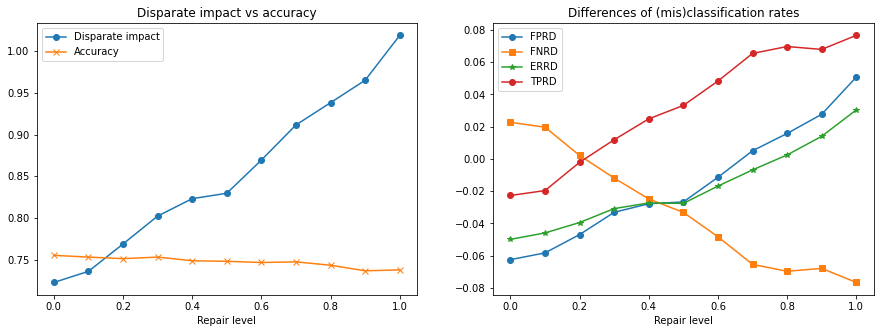

In [14]:
# Visualization of results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5)) # [1 x 2] grid
ax1.plot(np.arange(0., 1.1, 0.1), di_list, marker='o')
ax1.plot(np.arange(0., 1.1, 0.1), accuracy_list, marker='x')
ax1.set_xlabel('Repair level')
ax1.legend(['Disparate impact', 'Accuracy'])
ax1.set_title('Disparate impact vs accuracy')
ax2.plot(np.arange(0., 1.1, 0.1), fprd_list, marker='o')
ax2.plot(np.arange(0., 1.1, 0.1), fnrd_list, marker='s')
ax2.plot(np.arange(0., 1.1, 0.1), errd_list, marker='*')
ax2.plot(np.arange(0., 1.1, 0.1), tprd_list, marker='o')
ax2.set_xlabel('Repair level')
ax2.legend(['FPRD', 'FNRD', 'ERRD', 'TPRD'])
ax2.set_title('Differences of (mis)classification rates')
plt.show()

### Comments
- The fairness-unaware performance of the Logistic Regression model is obtained with repair_level=0, for a specified set of model hyperparameters e.g. solver. For example, the newton-cg solver achieves better accuracy than liblinear solver, however the bias removal task is more challenging.
- By increasing the **repair_level**, disparate impact score increases resulting to a fairer classifier; at the same time, the **accuracy** is not affected. For repair_level=1 we achieve the best disparate impact ratio equal to 0.95.
- As far as **(mis)classification rate differences** are concerned, by removing disparate impact the respective FPRD and FNRD metrics are also reduced, up until a point (repair_level~0.4) where they reach a value close to 0. By increasing repair_level more than this threshold, the differences begin to increase again, in the opposite direction.

**Note**: brief explanation of the (mis)classification rate differences that are included in the second plot:
- **FPRD** (False Positive Rate Difference): $FPR_{D=unprivileged}−FPR_{D=privileged}$
- **FNRD** (False Negative Rate Difference): $FNR_{D=unprivileged}−FNR_{D=privileged}$
- **ERRD** (Error Rate Difference): Difference in error rates for unprivileged and privileged groups, $ERR_{D=unprivileged}−ERR_{D=privileged}$, and $ERR=(FP+FN)/(P+N)$

##### TEST DATA METRICS

Base rate on entire population: 0.38
Base rate on privileged group (white) :0.38
Base rate on unprivileged group (black) :0.39
Statistical parity difference: 0.01
Disparate impact: 1.02


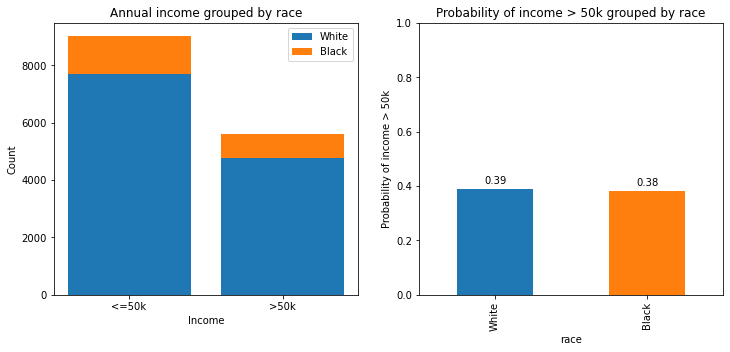

In [18]:
# Visualize bias in repaired test set

# Create dataframe from test set
race = ad_test_rep_pred.features[:,protected_idx]
inc = ad_test_rep_pred.labels
ad_test_rep_pred_df = pd.DataFrame({'race':race, 'income-per-year':inc})
# Call fairness analysis function
analyze_fairness(ad_test_rep_pred, ad_test_rep_pred_df)

# TASK 3

In [ ]:
pre_fairness = lr2.fit(X_train,y_train)
post_fairness = lr.fit(X_train, y_train)

In [ ]:
report.compare(X_test, y_test, test['sex'], pre_fairness, pred_type="regression")